## VanAcker Notebook 10.7 PyMc

### 1.) Generate Data for Poisson Regression

I generated data to describe conditions in a pond that may affect the count of parasites in a frog. The predictor variables were whether the pond had a high nutrient load or no added nutrients and if the area surrounding the pond was natural or not-natural (suburban or more developed). These predictors were described with True or False statements and every combination of the predictors described the response variable of parasite count.

In [2]:
%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))



Running on PyMC3 v3.3


In [20]:
# Set poisson parameter - theta - the mean number of occurrences - has to be >0
theta_nonutr_nat = 5    # no nutrients, natural
theta_nutr_nat = 18      # nutrients, natural
theta_nonutr_nonat = 12 # no nutrients, not natural
theta_nutr_nonat = 25   # nutrients, not natural


# create samples
q = 500 # this will produce 2000 rows bc. T/F will double samaple count
df = pd.DataFrame({
        'numpar': np.concatenate((np.random.poisson(theta_nonutr_nat, q), # draws samples from poisson distribution
                                   np.random.poisson(theta_nutr_nat, q),
                                   np.random.poisson(theta_nonutr_nonat, q),
                                   np.random.poisson(theta_nutr_nonat, q))),
        'nutrients': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'natural': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [21]:
df.tail()

,natural,numpar,nutrients
1995,True,27,True
1996,True,31,True
1997,True,24,True
1998,True,31,True
1999,True,23,True


### View means of the poisson combinations

In [22]:
df.groupby(['natural','nutrients']).mean().unstack()

numpar        
nutrients   False   True 
natural                  
False       4.882  17.986
True       11.944  25.106

These means approximately match the theta values set above.

### Plot the Distributions

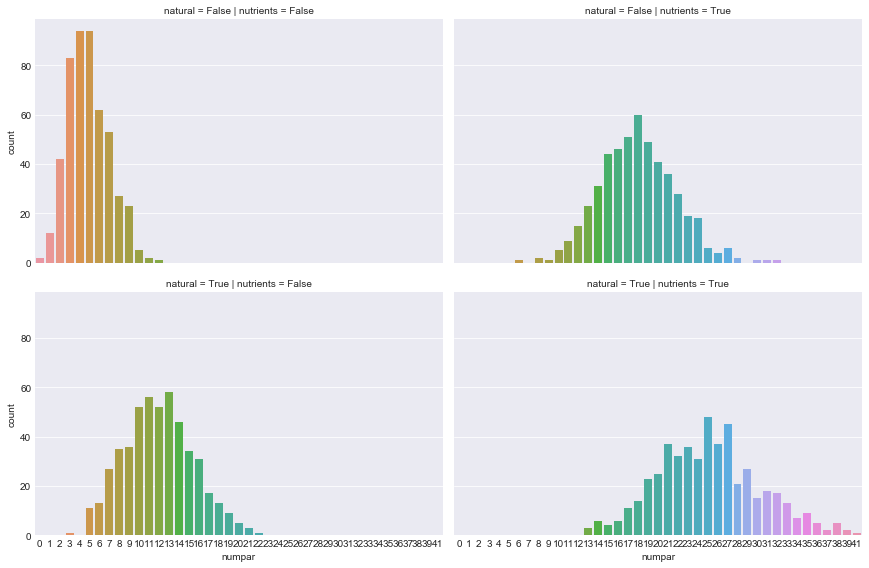

In [23]:
g = sns.factorplot(x='numpar', row='natural', col='nutrients', data=df,
               kind='count', size=4, aspect=1.5)

### Interpretation of Plots:

When frogss are in high nutrient ponds the count of parasites is higher than in low nutrient ponds. However the natural pond with no nutrients has a higher parasite count than the not-natural ponds with no nutrients which is not expected.  
    
    
    
    


### Linear model of interactions

In [32]:
fml = 'numpar ~ nutrients * natural'  # full patsy formulation

### Define Model 

In [33]:
with pm.Model() as parmodel:

    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

In [36]:
# get maximum a posteriori estimate - the local maximum point 
map_estimate = pm.find_MAP(model=parmodel)
map_estimate

logp = -5,330.7, ||grad|| = 0.15114: 100%|██████████| 23/23 [00:00<00:00, 708.21it/s]  


{'Intercept': array(1.5855503597521599),
 'mu': array(0.9999302483464333),
 'mu_log__': array(-6.975408632643905e-05),
 'natural[T.True]': array(0.8946793290604684),
 'nutrients[T.True]': array(1.304043699200551),
 'nutrients[T.True]:natural[T.True]': array(-0.5611670959123951)}

In [37]:
with parmodel:
    trace = pm.sample(10000, chains = 2)[2000:]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__, nutrients[T.True]:natural[T.True], natural[T.True], nutrients[T.True], Intercept]
100%|██████████| 10500/10500 [01:00<00:00, 173.57it/s]
The acceptance probability does not match the target. It is 0.878840025081, but should be close to 0.8. Try to increase the number of tuning steps.


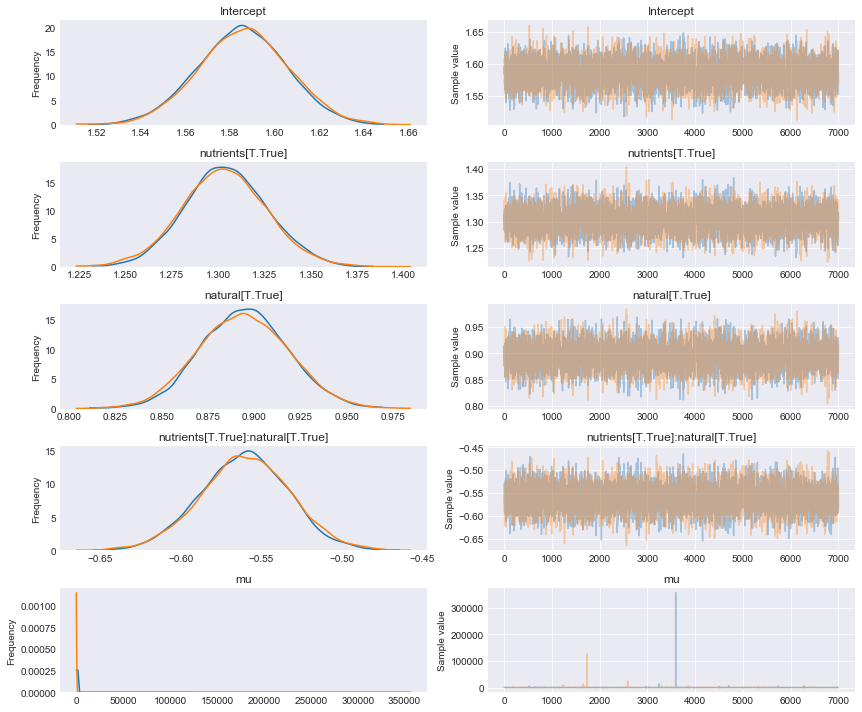

In [38]:
pm.traceplot(trace[1000:]);

All of chains in the model converged fairly quickly and the trace plots overall look good, except for mu. When I changed the iterations from 4000 to 10,000 the chains aligned better on the left side plots. Mu may not be estimated well here.

### Estimate Parameter Posteriors

Compare the mean number of parasites with the estimated mean

In [44]:
df['numpar'].mean()

14.9795

In [45]:
np.percentile(trace['mu'], [25,50,75])

array([  4.16799694,   9.98952475,  24.37969363])

9.98 estimate is somewhat close to the mean parasite count of 14.

In [46]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,1.585780,0.020234,0.000331,1.547101,1.626782,4184.0,1.000484
nutrients[T.True],1.303610,0.022715,0.000363,1.259792,1.349246,4258.0,1.000215
natural[T.True],0.894227,0.023976,0.000392,0.846807,0.940610,4091.0,1.000293
nutrients[T.True]:natural[T.True],-0.560595,0.027621,0.000444,-0.615282,-0.507166,4190.0,1.000095
mu,85.699333,3121.668912,27.831242,0.006708,126.437717,12515.0,0.999938


In [47]:
np.exp(pm.summary(trace)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,4.883100e+00,4.697830,5.087477e+00
nutrients[T.True],3.682568e+00,3.524688,3.854520e+00
natural[T.True],2.445445e+00,2.332188,2.561544e+00
nutrients[T.True]:natural[T.True],5.708691e-01,0.540489,6.021996e-01
mu,1.654807e+37,1.006731,8.150850e+54


The HPD (highest posterior density) shows the collection of most likely values for the parameter estimates. In the summary plot all of the means for the parameters fall within the HPD 2.5 and HPD 97.5, except for mu. The intervals look good as they are not too large of a range surrounding the mean.

However, the model did not do a great job predicting the values I set for the parameters as seen by the first summary plot means for trace.